### Implementation

In [1]:
import torch
import numpy as np
import copy
import os
from pathlib import Path
import cv2
import shutil

from demo import TrajCrafter
from models.utils import Warper, read_video_frames, sphere2pose, save_video
import torch.nn.functional as F
from tqdm import tqdm

from models.infer import DepthCrafterDemo

import os
from datetime import datetime
import torch
import copy
import time
import sys
import tempfile
from pathlib import Path

# Add core.py to path if needed
sys.path.append('/home/azhuravl/work/TrajectoryCrafter/notebooks/28_08_25_trajectories')
from core import VisualizationWarper

sys.path.append('/home/azhuravl/work/TrajectoryCrafter/notebooks/06_10_25_vggt')
from parsing import get_parser


class TrajCrafterAutoregressive(TrajCrafter):
    def __init__(self, opts):
        super().__init__(opts)

        # self.funwarp = VisualizationWarper(device=opts.device)
        self.prompt = None
        
        self.K = torch.tensor(
            [[500, 0.0, 512.], [0.0, 500, 288.], [0.0, 0.0, 1.0]]
            ).repeat(opts.video_length, 1, 1).to(opts.device)

/CT/video_4d_recon/nobackup/conda_envs/trajcrafter/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/CT/video_4d_recon/nobackup/conda_envs/trajcrafter/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


In [138]:
sys.argv = [
    "",
    "--video_path", "/home/azhuravl/nobackup/DAVIS_testing/trainval/rhino.mp4",
    "--n_splits", "2",
    "--overlap_frames", "0",
    "--radius", "0",
    "--mode", "gradual",
]

parser = get_parser()
opts_base = parser.parse_args()

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
video_basename = os.path.splitext(os.path.basename(opts_base.video_path))[0]

# Setup
opts_base.weight_dtype = torch.bfloat16
opts_base.exp_name = f"{video_basename}_{timestamp}_autoregressive"
opts_base.save_dir = os.path.join(opts_base.out_dir, opts_base.exp_name)

# Create TrajCrafterVisualization instance for autoregressive generation
radius = opts_base.radius

variants = [
    ("right_90", [0, 90, radius, 0, 0]),
]
# name = "right_90"
# pose = [0, 90, radius, 0, 0]

# name = "top_90"
# pose = [90, 0, radius, 0, 0]

pose = [120, 0, 0, 0, 1]
# name = '120_0_0_0_3', make it infer values from pose
name = f"{pose[0]}_{pose[1]}_{pose[2]}_{pose[3]}_{pose[4]}"


print(f"\n=== Running Autoregressive {name} ===")
opts = copy.deepcopy(opts_base)
opts.exp_name = f"{video_basename}_{timestamp}_{name}_auto_s{opts_base.n_splits}"
opts.save_dir = os.path.join(opts.out_dir, opts.exp_name)
opts.camera = "target"
opts.target_pose = pose
opts.traj_txt = 'test/trajs/loop2.txt'

# Make directories
os.makedirs(opts.save_dir, exist_ok=True)



=== Running Autoregressive 120_0_0_0_1 ===


In [ ]:


class TrajCrafterVisualization(TrajCrafter):
    """Lightweight TrajCrafter subclass for camera trajectory visualization"""
    
    def __init__(self, opts):
        # Only initialize what we need for pose generation and depth estimation
        self.device = opts.device
        self.depth_estimater = DepthCrafterDemo(
            unet_path=opts.unet_path,
            pre_train_path=opts.pre_train_path,
            cpu_offload=opts.cpu_offload,
            device=opts.device,
        )
        print("TrajCrafterVisualization initialized (diffusion pipeline skipped)")
    
    def extract_scene_data(self, opts):
        """Extract all data needed for 3D visualization"""
        print("Reading video frames...")
        frames = read_video_frames(
            opts.video_path, opts.video_length, opts.stride, opts.max_res
        )
        
        print("Estimating depth...")
        depths = self.depth_estimater.infer(
            frames,
            opts.near,
            opts.far,
            opts.depth_inference_steps,
            opts.depth_guidance_scale,
            window_size=opts.window_size,
            overlap=opts.overlap,
        ).to(opts.device)
        
        print("Converting frames to tensors...")
        frames_tensor = (
            torch.from_numpy(frames).permute(0, 3, 1, 2).to(opts.device) * 2.0 - 1.0
        )
        
        print("Generating camera poses...")
        pose_s, pose_t, K = self.get_poses(opts, depths, num_frames=opts.video_length)
        
        # Calculate scene radius
        radius = (
            depths[0, 0, depths.shape[-2] // 2, depths.shape[-1] // 2].cpu()
            * opts.radius_scale
        )
        radius = min(radius, 5)
        
        return {
            'frames_numpy': frames,
            'frames_tensor': frames_tensor,
            'depths': depths,
            'pose_source': pose_s,
            'pose_target': pose_t,
            'intrinsics': K,
            'radius': radius,
            'trajectory_params': opts.target_pose if hasattr(opts, 'target_pose') else None
        }
        
    
    def infer_gradual(self, opts):
        frames = read_video_frames(
            opts.video_path, opts.video_length, opts.stride, opts.max_res
        )
        # depths= self.depth_estimater.infer(frames, opts.near, opts.far).to(opts.device)
        depths = self.depth_estimater.infer(
            frames,
            opts.near,
            opts.far,
            opts.depth_inference_steps,
            opts.depth_guidance_scale,
            window_size=opts.window_size,
            overlap=opts.overlap,
        ).to(opts.device)
        frames = (
            torch.from_numpy(frames).permute(0, 3, 1, 2).to(opts.device) * 2.0 - 1.0
        )  # 49 576 1024 3 -> 49 3 576 1024, [-1,1]
        assert frames.shape[0] == opts.video_length
        pose_s, pose_t, K = self.get_poses(opts, depths, num_frames=opts.video_length)
        warped_images = []
        masks = []
        for i in tqdm(range(opts.video_length)):
            warped_frame2, mask2, warped_depth2, flow12 = self.funwarp.forward_warp(
                frames[i : i + 1],
                None,
                depths[i : i + 1],
                pose_s[i : i + 1],
                pose_t[i : i + 1],
                K[i : i + 1],
                None,
                opts.mask,
                twice=False,
            )
            warped_images.append(warped_frame2)
            masks.append(mask2)
        cond_video = (torch.cat(warped_images) + 1.0) / 2.0
        cond_masks = torch.cat(masks)

        frames = F.interpolate(
            frames, size=opts.sample_size, mode='bilinear', align_corners=False
        )
        cond_video = F.interpolate(
            cond_video, size=opts.sample_size, mode='bilinear', align_corners=False
        )
        cond_masks = F.interpolate(cond_masks, size=opts.sample_size, mode='nearest')
        save_video(
            (frames.permute(0, 2, 3, 1) + 1.0) / 2.0,
            os.path.join(opts.save_dir, 'input.mp4'),
            fps=opts.fps,
        )
        save_video(
            cond_video.permute(0, 2, 3, 1),
            os.path.join(opts.save_dir, 'render.mp4'),
            fps=opts.fps,
        )
        save_video(
            cond_masks.repeat(1, 3, 1, 1).permute(0, 2, 3, 1),
            os.path.join(opts.save_dir, 'mask.mp4'),
            fps=opts.fps,
        )

        frames = (frames.permute(1, 0, 2, 3).unsqueeze(0) + 1.0) / 2.0
        frames_ref = frames[:, :, :10, :, :]
        cond_video = cond_video.permute(1, 0, 2, 3).unsqueeze(0)
        cond_masks = (1.0 - cond_masks.permute(1, 0, 2, 3).unsqueeze(0)) * 255.0
        generator = torch.Generator(device=opts.device).manual_seed(opts.seed)

        return cond_video, cond_masks
        

In [4]:
vis_crafter = TrajCrafterAutoregressive(opts_base)

Expected types for unet: ['UNetSpatioTemporalConditionModel'], got DiffusersUNetSpatioTemporalConditionModelDepthCrafter.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/CT/video_4d_recon/nobackup/conda_envs/trajcrafter/lib/python3.10/site-packages/diffusers/models/embeddings.py:186: FutureWarning: `get_3d_sincos_pos_embed` uses `torch` and supports `device`. `from_numpy` is no longer required.  Pass `output_type='pt' to use the new version now.
  deprecate("output_type=='np'", "0.33.0", deprecation_message, standard_warn=False)
/CT/video_4d_recon/nobackup/conda_envs/trajcrafter/lib/python3.10/site-packages/diffusers/models/embeddings.py:304: FutureWarning: `get_2d_sincos_pos_embed_from_grid` uses `torch` and supports `device`. `from_numpy` is no longer required.  Pass `output_type='pt' to use the new version now.
  deprecate("output_type=='np'", "0.33.0", deprecation_message, standard_warn=False)
/CT/video_4d_recon/nobackup/conda_envs/trajcrafter/lib/python3.10/site-packages/diffusers/models/embeddings.py:337: FutureWarning: `get_1d_sincos_pos_embed_from_grid` uses `torch` and supports `device`. `from_numpy` is no longer required.  Pass `output_type=

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
import torch
import numpy as np
import copy

from demo import TrajCrafter
from models.utils import Warper, read_video_frames
from models.infer import DepthCrafterDemo
import inference_orbits


# Cell 3: Visualization Classes
class VisualizationWarper(Warper):
    """Extended Warper class for 3D visualization"""
    
    def extract_3d_points_with_colors(
        self,
        frame1: torch.Tensor,
        depth1: torch.Tensor,
        transformation1: torch.Tensor,
        intrinsic1: torch.Tensor,
        subsample_step: int = 10
    ):
        """Extract 3D world points and their corresponding colors for visualization"""
        b, c, h, w = frame1.shape
        
        # Move tensors to device
        frame1 = frame1.to(self.device).to(self.dtype)
        depth1 = depth1.to(self.device).to(self.dtype)
        transformation1 = transformation1.to(self.device).to(self.dtype)
        intrinsic1 = intrinsic1.to(self.device).to(self.dtype)
        
        # Create subsampled pixel coordinates for performance
        x_coords = torch.arange(0, w, subsample_step, dtype=torch.float32)
        y_coords = torch.arange(0, h, subsample_step, dtype=torch.float32)
        
        
        x2d, y2d = torch.meshgrid(x_coords, y_coords, indexing='xy')
        # x2d, y2d = torch.meshgrid(x_coords, y_coords, indexing='ij')
        x2d = x2d.to(depth1.device)
        y2d = y2d.to(depth1.device)
        ones_2d = torch.ones_like(x2d)
        
        # Stack into homogeneous coordinates
        pos_vectors_homo = torch.stack([x2d, y2d, ones_2d], dim=2)[None, :, :, :, None]
        
        # Subsample depth and colors
        depth_sub = depth1[:, 0, ::subsample_step, ::subsample_step]
        colors_sub = frame1[:, :, ::subsample_step, ::subsample_step]
        
        # Unproject to 3D camera coordinates
        intrinsic1_inv = torch.linalg.inv(intrinsic1)
        intrinsic1_inv_4d = intrinsic1_inv[:, None, None]
        depth_4d = depth_sub[:, :, :, None, None]
        
        unnormalized_pos = torch.matmul(intrinsic1_inv_4d, pos_vectors_homo)
        
        # print('depth_4d', depth_4d.shape)
        # print('unnormalized_pos', unnormalized_pos.shape)
        
        camera_points = depth_4d * unnormalized_pos
        
        # Transform to world coordinates
        ones_4d = torch.ones(b, camera_points.shape[1], camera_points.shape[2], 1, 1).to(depth1)
        world_points_homo = torch.cat([camera_points, ones_4d], dim=3)
        trans_4d = transformation1[:, None, None]
        world_points_homo = torch.matmul(trans_4d, world_points_homo)
        world_points = world_points_homo[:, :, :, :3, 0]  # (b, h_sub, w_sub, 3)
        
        # Prepare colors
        colors = colors_sub.permute(0, 2, 3, 1)  # (b, h_sub, w_sub, 3)
        
        # Filter valid points (positive depth)
        valid_mask = depth_sub > 0  # (b, h_sub, w_sub)
        
        # Flatten and filter
        points_3d = world_points[valid_mask]  # (N, 3)
        colors_rgb = colors[valid_mask]       # (N, 3)
        
        return points_3d, colors_rgb
    

    def render_pointcloud_native_v2(
        self,
        points_3d: torch.Tensor,
        colors_3d: torch.Tensor,
        transformation_target: torch.Tensor,
        intrinsic_target: torch.Tensor,
        image_size: tuple = (576, 1024),
        mask: bool = False
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Render point cloud by creating synthetic depth/frame and using forward_warp
        """
        
        print("using warper v2!!!")
        
        h, w = image_size
        b = transformation_target.shape[0]
        device = self.device
        
        # Create a synthetic source frame with our point cloud data
        source_frame = torch.full((b, 3, h, w), -1.0, device=device, dtype=self.dtype)
        source_depth = torch.zeros(b, 1, h, w, device=device, dtype=self.dtype)
        source_mask = torch.zeros(b, 1, h, w, device=device, dtype=self.dtype)
        
        # Project world points to source camera (identity transformation)
        identity_transform = torch.eye(4, device=device, dtype=self.dtype).unsqueeze(0).repeat(b, 1, 1)
        
        # Convert world points to camera coordinates for the source view
        ones = torch.ones(points_3d.shape[0], 1, device=device, dtype=self.dtype)
        world_points_homo = torch.cat([points_3d, ones], dim=1)
        
        # For source camera, we can use identity or extract the original transformation
        # Let's assume we're rendering from an identity camera position
        camera_points = points_3d  # For identity camera position
        
        # Project to 2D
        projected_homo = torch.matmul(intrinsic_target[0], camera_points.T).T
        pixel_coords = projected_homo[:, :2] / projected_homo[:, 2:3]
        depths_vals = camera_points[:, 2]
        
        # Filter valid points
        valid_mask = (depths_vals > 0.01) & \
                    (pixel_coords[:, 0] >= 0) & (pixel_coords[:, 0] < w) & \
                    (pixel_coords[:, 1] >= 0) & (pixel_coords[:, 1] < h)
        
        if valid_mask.sum() == 0:
            return (torch.full((b, 3, h, w), -1.0, device=device, dtype=self.dtype),
                    torch.zeros(b, 1, h, w, device=device, dtype=self.dtype))
        
        valid_coords = pixel_coords[valid_mask]
        valid_colors = colors_3d[valid_mask]
        valid_depths = depths_vals[valid_mask]
        
        # Fill source frame/depth with our data
        x_int = torch.clamp(torch.round(valid_coords[:, 0]).long(), 0, w-1)
        y_int = torch.clamp(torch.round(valid_coords[:, 1]).long(), 0, h-1)
        
        for i in range(len(x_int)):
            x, y = x_int[i], y_int[i]
            source_frame[0, :, y, x] = valid_colors[i]
            source_depth[0, 0, y, x] = valid_depths[i]
            source_mask[0, 0, y, x] = 1.0
        
        # Now use the warper's forward_warp method
        warped_frame, warped_mask, _, _ = self.forward_warp(
            source_frame,
            source_mask,
            source_depth,
            identity_transform,  # Source transformation (identity)
            transformation_target,  # Target transformation
            intrinsic_target,
            None,  # Use same intrinsics
            mask=mask,
            twice=False
        )
        
        print(f"Final warped range: [{warped_frame.min():.3f}, {warped_frame.max():.3f}]")
        print(f"Valid pixels: {warped_mask.sum().item()}")
        
        return warped_frame, warped_mask


In [6]:
from typing import Optional, Tuple, List
import torch

class GlobalPointCloudWarper(Warper):
    def __init__(self, resolution: tuple = None, device: str = 'cuda', max_points: int = 1000000):
        super().__init__(resolution, device)
        self.max_points = max_points
        self.device = device
    
    def lift_to_3d_pointcloud(
        self,
        frame1: torch.Tensor,
        mask1: Optional[torch.Tensor],
        depth1: torch.Tensor,
        transformation1: torch.Tensor,
        intrinsic1: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Lift 2D image points to 3D world coordinates with colors.
        """
        if self.resolution is not None:
            assert frame1.shape[2:4] == self.resolution
        b, c, h, w = frame1.shape
        if mask1 is None:
            mask1 = torch.ones(size=(b, 1, h, w), device=self.device, dtype=self.dtype)

        # Move tensors to device and convert to proper dtype
        frame1 = frame1.to(self.device).to(self.dtype)
        mask1 = mask1.to(self.device).to(self.dtype)
        depth1 = depth1.to(self.device).to(self.dtype)
        transformation1 = transformation1.to(self.device).to(self.dtype)
        intrinsic1 = intrinsic1.to(self.device).to(self.dtype)

        # Create pixel coordinates directly on device
        x1d = torch.arange(0, w, device=self.device, dtype=self.dtype)[None]
        y1d = torch.arange(0, h, device=self.device, dtype=self.dtype)[:, None]
        x2d = x1d.repeat([h, 1])  # (h, w)
        y2d = y1d.repeat([1, w])  # (h, w)
        ones_2d = torch.ones(size=(h, w), device=self.device, dtype=self.dtype)  # (h, w)
        
        pos_vectors_homo = torch.stack([x2d, y2d, ones_2d], dim=2)[
            None, :, :, :, None
        ]  # (1, h, w, 3, 1)

        # Rest of the function remains the same...
        intrinsic1_inv = torch.linalg.inv(intrinsic1)  # (b, 3, 3)
        intrinsic1_inv_4d = intrinsic1_inv[:, None, None]  # (b, 1, 1, 3, 3)
        depth_4d = depth1[:, 0][:, :, :, None, None]  # (b, h, w, 1, 1)

        unnormalized_pos = torch.matmul(
            intrinsic1_inv_4d, pos_vectors_homo
        )  # (b, h, w, 3, 1)
        
        # Get 3D points in camera coordinate system
        camera_points = depth_4d * unnormalized_pos  # (b, h, w, 3, 1)
        
        # Transform to world coordinates
        ones_4d = torch.ones(size=(b, h, w, 1, 1), device=self.device, dtype=self.dtype)
        camera_points_homo = torch.cat([camera_points, ones_4d], dim=3)  # (b, h, w, 4, 1)
        
        # Apply inverse transformation to get world coordinates
        transformation1_inv = torch.linalg.inv(transformation1)  # (b, 4, 4)
        transformation1_inv_4d = transformation1_inv[:, None, None]  # (b, 1, 1, 4, 4)
        world_points_homo = torch.matmul(transformation1_inv_4d, camera_points_homo)  # (b, h, w, 4, 1)
        world_points = world_points_homo[:, :, :, :3, 0]  # (b, h, w, 3)
        
        # Get colors (convert from channel-first to spatial layout)
        colors = frame1.permute(0, 2, 3, 1)  # (b, h, w, 3)
        
        # Apply mask to filter out invalid points
        valid_mask = mask1[:, 0, :, :].unsqueeze(-1)  # (b, h, w, 1)
        world_points = world_points * valid_mask
        colors = colors * valid_mask
        
        return world_points, colors

    def create_pointcloud_from_image(
        self,
        frame: torch.Tensor,
        mask: Optional[torch.Tensor],
        depth: torch.Tensor,
        transformation: torch.Tensor,
        intrinsic: torch.Tensor,
        confidence_weight: float = 1.0
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Create a point cloud from a single image"""
        # Ensure all inputs are on the correct device
        frame = frame.to(self.device).to(self.dtype)
        depth = depth.to(self.device).to(self.dtype)
        transformation = transformation.to(self.device).to(self.dtype)
        intrinsic = intrinsic.to(self.device).to(self.dtype)
        
        if mask is not None:
            mask = mask.to(self.device).to(self.dtype)
        
        # Lift 2D points to 3D world coordinates
        world_points, colors = self.lift_to_3d_pointcloud(
            frame, mask, depth, transformation, intrinsic
        )
        
        # Flatten to point cloud format
        b, h, w, _ = world_points.shape
        if mask is None:
            mask = torch.ones(b, 1, h, w, device=self.device, dtype=self.dtype)
            
        # Only keep valid points
        valid_mask = mask[:, 0, :, :].bool()  # (b, h, w)
        
        points = world_points[valid_mask]  # (N_valid, 3)
        point_colors = colors[valid_mask]  # (N_valid, 3)
        weights = torch.full(
            (points.shape[0], 1), 
            confidence_weight, 
            device=self.device, 
            dtype=self.dtype
        )
        
        return points, point_colors, weights
    
    def merge_pointclouds(
        self,
        point_clouds: List[torch.Tensor],
        colors_list: List[torch.Tensor], 
        weights_list: List[torch.Tensor]
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Merge multiple point clouds into one"""
        if not point_clouds:
            return None, None, None
            
        merged_points = torch.cat(point_clouds, dim=0)
        merged_colors = torch.cat(colors_list, dim=0)
        merged_weights = torch.cat(weights_list, dim=0)
        
        return merged_points, merged_colors, merged_weights
    
    def downsample_pointcloud(
        self,
        points: torch.Tensor,
        colors: torch.Tensor,
        weights: torch.Tensor,
        max_points: Optional[int] = None
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Downsample a point cloud to max_points"""
        if max_points is None:
            max_points = self.max_points
            
        if points.shape[0] <= max_points:
            return points, colors, weights
            
        # Random sampling weighted by confidence
        probabilities = (weights / weights.sum()).squeeze()
        indices = torch.multinomial(probabilities, max_points, replacement=False)
        
        return points[indices], colors[indices], weights[indices]
    
    def render_from_camera(
        self,
        points: torch.Tensor,
        colors: torch.Tensor,
        weights: torch.Tensor,
        transformation: torch.Tensor,
        intrinsic: torch.Tensor,
        target_height: int,
        target_width: int,
        depth_threshold: float = 100000.0,
        point_size: float = 2.0,  # Add this parameter
        use_bilinear: bool = True,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Render point cloud from a target camera viewpoint
        
        :param points: (N, 3) world coordinates  
        :param colors: (N, 3) RGB colors
        :param weights: (N, 1) confidence weights
        :param transformation: (b, 4, 4) target camera extrinsic matrix
        :param intrinsic: (b, 3, 3) target camera intrinsic matrix
        :param target_height: output image height
        :param target_width: output image width
        :param depth_threshold: maximum depth to render
        :return: rendered_image: (b, 3, h, w), mask: (b, 1, h, w)
        """
        if points is None or points.shape[0] == 0:
            b = transformation.shape[0]
            return (
                torch.zeros(b, 3, target_height, target_width, device=self.device),
                torch.zeros(b, 1, target_height, target_width, device=self.device)
            )
        
        b = transformation.shape[0]
        point_count = points.shape[0]
        
        # Transform world points to camera coordinates
        points_homo = torch.cat([
            points, 
            torch.ones(point_count, 1, device=self.device)
        ], dim=1)  # (N, 4)
        
        # Apply transformation for each batch item
        rendered_images = []
        rendered_masks = []
        
        for batch_idx in range(b):
            # Transform to camera space
            camera_points_homo = torch.matmul(
                transformation[batch_idx], points_homo.T
            ).T  # (N, 4)
            camera_points = camera_points_homo[:, :3]  # (N, 3)
            
            # Filter points behind camera and too far
            valid_depth = (camera_points[:, 2] > 0.1) & (camera_points[:, 2] < depth_threshold)
            valid_points = camera_points[valid_depth]
            valid_colors = colors[valid_depth]
            valid_weights = weights[valid_depth]
            
            if valid_points.shape[0] == 0:
                rendered_images.append(torch.zeros(3, target_height, target_width, device=self.device))
                rendered_masks.append(torch.zeros(1, target_height, target_width, device=self.device))
                continue
            
            # Project to 2D
            projected = torch.matmul(intrinsic[batch_idx], valid_points.T).T  # (N, 3)
            pixel_coords = projected[:, :2] / projected[:, 2:3]  # (N, 2)
            depths = projected[:, 2]  # (N,)
            
            # Filter points outside image bounds
            in_bounds = (
                (pixel_coords[:, 0] >= 0) & (pixel_coords[:, 0] < target_width) &
                (pixel_coords[:, 1] >= 0) & (pixel_coords[:, 1] < target_height)
            )
            
            final_coords = pixel_coords[in_bounds]
            final_colors = valid_colors[in_bounds]
            final_depths = depths[in_bounds]
            final_weights = valid_weights[in_bounds]
            
            # Choose splatting method
            if use_bilinear:
                rendered_image, rendered_mask = self._splat_points_bilinear_efficient(
                    final_coords, final_colors, final_depths, final_weights,
                    target_height, target_width
                )
            else:
                rendered_image, rendered_mask = self._splat_points_to_image_with_size(
                    final_coords, final_colors, final_depths, final_weights,
                    target_height, target_width, point_size=point_size
                )
            
            rendered_images.append(rendered_image)
            rendered_masks.append(rendered_mask)
        
        return (
            torch.stack(rendered_images, dim=0),
            torch.stack(rendered_masks, dim=0)
        )
    
    def _splat_points_to_image_with_size(
        self,
        coords: torch.Tensor,  # (N, 2)
        colors: torch.Tensor,  # (N, 3)
        depths: torch.Tensor,  # (N,)
        weights: torch.Tensor,  # (N, 1)
        height: int,
        width: int,
        point_size: float = 2.0  # Controllable point size
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Render points with controllable size to avoid holes"""
        
        if coords.shape[0] == 0:
            return (
                torch.zeros(3, height, width, device=self.device),
                torch.zeros(1, height, width, device=self.device)
            )
        
        # Depth weighting
        normalized_depths = depths / (depths.max() + 1e-8)
        depth_weights = torch.exp(-normalized_depths * 2)
        total_weights = weights.squeeze() * depth_weights
        
        # Create splat pattern based on point size
        radius = int(point_size / 2)
        offsets = []
        splat_weights = []
        
        for dy in range(-radius, radius + 1):
            for dx in range(-radius, radius + 1):
                dist = (dx**2 + dy**2)**0.5
                if dist <= point_size / 2:
                    offsets.append([dx, dy])
                    # Gaussian falloff
                    weight = torch.exp(torch.tensor(-dist**2 / (2 * (point_size/4)**2)))
                    splat_weights.append(weight)
        
        offsets = torch.tensor(offsets, device=self.device)
        splat_weights = torch.tensor(splat_weights, device=self.device)
        
        # Expand coordinates for all splat positions
        n_points = coords.shape[0]
        n_splats = len(offsets)
        
        # Repeat coordinates for each splat offset
        expanded_coords = coords[:, None, :] + offsets[None, :, :]  # (N, n_splats, 2)
        expanded_coords = expanded_coords.view(-1, 2)  # (N*n_splats, 2)
        
        # Repeat colors and weights
        expanded_colors = colors[:, None, :].repeat(1, n_splats, 1).view(-1, 3)
        expanded_weights = total_weights[:, None].repeat(1, n_splats).view(-1)
        expanded_splat_weights = splat_weights[None, :].repeat(n_points, 1).view(-1)
        
        # Apply splat weights
        final_weights = expanded_weights * expanded_splat_weights
        
        # Filter out-of-bounds
        pixel_coords = torch.round(expanded_coords).long()
        valid_mask = (
            (pixel_coords[:, 0] >= 0) & (pixel_coords[:, 0] < width) &
            (pixel_coords[:, 1] >= 0) & (pixel_coords[:, 1] < height)
        )
        
        if not valid_mask.any():
            return (
                torch.zeros(3, height, width, device=self.device),
                torch.zeros(1, height, width, device=self.device)
            )
        
        valid_coords = pixel_coords[valid_mask]
        valid_colors = expanded_colors[valid_mask]
        valid_weights = final_weights[valid_mask]
        
        # Render using scatter
        linear_indices = valid_coords[:, 1] * width + valid_coords[:, 0]
        
        color_buffer = torch.zeros(3, height * width, device=self.device)
        weight_buffer = torch.zeros(height * width, device=self.device)
        
        weighted_colors = valid_colors.T * valid_weights
        
        for c in range(3):
            color_buffer[c].scatter_add_(0, linear_indices, weighted_colors[c])
        
        weight_buffer.scatter_add_(0, linear_indices, valid_weights)
        
        # Normalize
        valid_pixels = weight_buffer > 1e-6
        color_buffer[:, valid_pixels] /= weight_buffer[valid_pixels]
        
        return color_buffer.view(3, height, width), valid_pixels.float().view(1, height, width)
    
    
    def _splat_points_bilinear_efficient(
        self,
        coords: torch.Tensor,  # (N, 2)
        colors: torch.Tensor,  # (N, 3)
        depths: torch.Tensor,  # (N,)
        weights: torch.Tensor,  # (N, 1)
        height: int,
        width: int
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Efficient bilinear splatting matching original warper behavior"""
        
        if coords.shape[0] == 0:
            return (
                torch.zeros(3, height, width, device=self.device),
                torch.zeros(1, height, width, device=self.device)
            )
        
        # Match original depth weighting
        # sat_depth = torch.clamp(depths, min=0.1, max=1000)
        # log_depth = torch.log(1 + sat_depth)
        # depth_weights = torch.exp(log_depth / log_depth.max() * 50)
        # point_weights = weights.squeeze() / depth_weights
        
        # Alternative: gentler depth weighting that preserves distant points
        normalized_depths = (depths - depths.min()) / (depths.max() - depths.min() + 1e-8)
        depth_weights = torch.exp(-normalized_depths * 2)  # Gentler falloff
        point_weights = weights.squeeze() * depth_weights
        
        
        # Bilinear interpolation coordinates (matches original)
        coords_floor = torch.floor(coords)
        coords_frac = coords - coords_floor
        
        # Four corner coordinates
        x0, y0 = coords_floor[:, 0].long(), coords_floor[:, 1].long()
        x1, y1 = x0 + 1, y0 + 1
        
        # Bilinear weights (exactly matches original implementation)
        dx, dy = coords_frac[:, 0], coords_frac[:, 1]
        w_nw = (1 - dx) * (1 - dy) * point_weights  # top-left
        w_ne = dx * (1 - dy) * point_weights        # top-right  
        w_sw = (1 - dx) * dy * point_weights        # bottom-left
        w_se = dx * dy * point_weights              # bottom-right
        
        # Vectorized approach: collect all coordinates and weights
        all_x = torch.cat([x0, x1, x0, x1])
        all_y = torch.cat([y0, y0, y1, y1])
        all_weights = torch.cat([w_nw, w_ne, w_sw, w_se])
        all_colors = torch.cat([colors, colors, colors, colors], dim=0)
        
        # Filter valid coordinates (within bounds and non-zero weight)
        valid_mask = (
            (all_x >= 0) & (all_x < width) &
            (all_y >= 0) & (all_y < height) &
            (all_weights > 1e-8)
        )
        
        if not valid_mask.any():
            return (
                torch.zeros(3, height, width, device=self.device),
                torch.zeros(1, height, width, device=self.device)
            )
        
        # Extract valid data
        valid_x = all_x[valid_mask]
        valid_y = all_y[valid_mask]
        valid_weights = all_weights[valid_mask]
        valid_colors = all_colors[valid_mask]
        
        # Convert to linear indices for scatter operations
        linear_indices = valid_y * width + valid_x
        
        # GPU-efficient scatter accumulation
        color_buffer = torch.zeros(3, height * width, device=self.device)
        weight_buffer = torch.zeros(height * width, device=self.device)
        
        # Vectorized color accumulation
        weighted_colors = valid_colors.T * valid_weights  # (3, N_valid)
        
        for c in range(3):
            color_buffer[c].scatter_add_(0, linear_indices, weighted_colors[c])
        
        weight_buffer.scatter_add_(0, linear_indices, valid_weights)
        
        # Normalize colors by accumulated weights
        valid_pixels = weight_buffer > 1e-8
        color_buffer[:, valid_pixels] /= weight_buffer[valid_pixels]
        
        # Reshape back to 2D
        color_image = color_buffer.view(3, height, width)
        mask_image = valid_pixels.float().view(1, height, width)
        
        return color_image, mask_image
        
    def render_pointcloud_zbuffer_vectorized(
        self,
        points_3d: torch.Tensor,
        colors_3d: torch.Tensor,
        transformation_target: torch.Tensor,
        intrinsic_target: torch.Tensor,
        image_size: tuple = (576, 1024)
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Fully vectorized Z-buffer rendering - no loops!
        """
        
        h, w = image_size
        device = self.device
        
        # Transform and project (same as before)
        ones = torch.ones(points_3d.shape[0], 1, device=device, dtype=self.dtype)
        world_points_homo = torch.cat([points_3d, ones], dim=1)
        camera_points_homo = torch.matmul(transformation_target[0], world_points_homo.T).T
        camera_points = camera_points_homo[:, :3]
        
        projected_homo = torch.matmul(intrinsic_target[0], camera_points.T).T
        pixel_coords = projected_homo[:, :2] / projected_homo[:, 2:3]
        depths_vals = camera_points[:, 2]
        
        # Filter valid points
        valid_mask = (depths_vals > 0.01) & \
                    (pixel_coords[:, 0] >= 0) & (pixel_coords[:, 0] < w) & \
                    (pixel_coords[:, 1] >= 0) & (pixel_coords[:, 1] < h)
        
        if valid_mask.sum() == 0:
            return (torch.full((1, 3, h, w), -1.0, device=device),
                    torch.zeros(1, 1, h, w, device=device))
        
        valid_coords = pixel_coords[valid_mask]
        valid_colors = colors_3d[valid_mask]
        valid_depths = depths_vals[valid_mask]
        
        # Convert to integer coordinates
        x_int = torch.clamp(torch.round(valid_coords[:, 0]).long(), 0, w-1)
        y_int = torch.clamp(torch.round(valid_coords[:, 1]).long(), 0, h-1)
        linear_indices = y_int * w + x_int
        
        # Vectorized Z-buffer using scatter_reduce (PyTorch 1.12+)
        # This finds the minimum depth per pixel and corresponding colors
        
        # Method 1: Use unique + scatter for closest point per pixel
        unique_indices, inverse_indices = torch.unique(linear_indices, return_inverse=True)
        
        # For each unique pixel, find the point with minimum depth
        min_depths = torch.full((len(unique_indices),), float('inf'), device=device)
        min_depths.scatter_reduce_(0, inverse_indices, valid_depths, reduce='amin')
        
        # Create mask for points that have minimum depth at their pixel
        expanded_min_depths = min_depths[inverse_indices]
        closest_mask = (valid_depths == expanded_min_depths)
        
        # Keep only the closest points
        final_indices = linear_indices[closest_mask]
        final_colors = valid_colors[closest_mask]
        final_depths = valid_depths[closest_mask]
        
        # Render final result
        color_buffer = torch.full((3, h * w), -1.0, device=device)
        depth_buffer = torch.full((h * w,), 0.0, device=device)
        
        # Scatter the closest colors (no conflicts now since we filtered to closest only)
        color_buffer[:, final_indices] = final_colors.T
        depth_buffer[final_indices] = final_depths
        
        # Reshape
        final_frame = color_buffer.view(3, h, w).unsqueeze(0)
        final_mask = (depth_buffer > 0).float().view(1, 1, h, w)
        
        return final_frame, final_mask
    
    
    def render_pointcloud_zbuffer_vectorized_point_size(
        self,
        points_3d: torch.Tensor,
        colors_3d: torch.Tensor,
        transformation_target: torch.Tensor,
        intrinsic_target: torch.Tensor,
        image_size: tuple = (576, 1024),
        point_size: int = 1
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Vectorized Z-buffer rendering with proper color handling for larger points
        """
        
        h, w = image_size
        device = self.device
        
        # Transform and project (same as before)
        ones = torch.ones(points_3d.shape[0], 1, device=device, dtype=self.dtype)
        world_points_homo = torch.cat([points_3d, ones], dim=1)
        camera_points_homo = torch.matmul(transformation_target[0], world_points_homo.T).T
        camera_points = camera_points_homo[:, :3]
        
        projected_homo = torch.matmul(intrinsic_target[0], camera_points.T).T
        pixel_coords = projected_homo[:, :2] / projected_homo[:, 2:3]
        depths_vals = camera_points[:, 2]
        
        # Filter valid points
        valid_mask = (depths_vals > 0.01) & \
                    (pixel_coords[:, 0] >= 0) & (pixel_coords[:, 0] < w) & \
                    (pixel_coords[:, 1] >= 0) & (pixel_coords[:, 1] < h)
        
        if valid_mask.sum() == 0:
            return (torch.full((1, 3, h, w), -1.0, device=device),
                    torch.zeros(1, 1, h, w, device=device))
        
        valid_coords = pixel_coords[valid_mask]
        valid_colors = colors_3d[valid_mask]
        valid_depths = depths_vals[valid_mask]
        
        # Generate splat pattern - FIXED VERSION
        if point_size == 1:
            splat_offsets = torch.tensor([[0, 0]], device=device)
            splat_weights = torch.tensor([1.0], device=device)
        else:
            radius = point_size // 2
            offsets = []
            weights = []
            
            for dy in range(-radius, radius + 1):
                for dx in range(-radius, radius + 1):
                    # Use square pattern with uniform weights
                    if abs(dx) <= radius and abs(dy) <= radius:
                        offsets.append([dx, dy])
                        
                        # OPTION 1: Uniform weights (prevents graying)
                        weights.append(1.0)
                        
                        # OPTION 2: Gentle falloff that preserves brightness
                        # dist = max(abs(dx), abs(dy))  # Square distance
                        # weight = 1.0 - (dist / (radius + 1)) * 0.3  # Only 30% falloff
                        # weights.append(weight)
            
            splat_offsets = torch.tensor(offsets, device=device)
            splat_weights = torch.tensor(weights, device=device)
        
        n_points = len(valid_coords)
        n_splats = len(splat_offsets)
        
        # Expand points for each splat offset
        expanded_coords = valid_coords[:, None, :] + splat_offsets[None, :, :]
        expanded_coords = expanded_coords.reshape(-1, 2)
        
        # Repeat colors and depths
        expanded_colors = valid_colors[:, None, :].repeat(1, n_splats, 1).reshape(-1, 3)
        expanded_depths = valid_depths[:, None].repeat(1, n_splats).reshape(-1)
        
        # DON'T multiply colors by splat weights - keep original intensity
        # expanded_colors = expanded_colors * expanded_splat_weights[:, None]  # REMOVE THIS
        
        # Convert to integer coordinates
        x_int = torch.round(expanded_coords[:, 0]).long()
        y_int = torch.round(expanded_coords[:, 1]).long()
        
        bounds_mask = (x_int >= 0) & (x_int < w) & (y_int >= 0) & (y_int < h)
        
        if bounds_mask.sum() == 0:
            return (torch.full((1, 3, h, w), -1.0, device=device),
                    torch.zeros(1, 1, h, w, device=device))
        
        final_x = x_int[bounds_mask]
        final_y = y_int[bounds_mask]
        final_colors = expanded_colors[bounds_mask]
        final_depths = expanded_depths[bounds_mask]
        
        linear_indices = final_y * w + final_x
        
        # Z-buffer logic (same as before)
        unique_indices, inverse_indices = torch.unique(linear_indices, return_inverse=True)
        
        min_depths = torch.full((len(unique_indices),), float('inf'), device=device)
        min_depths.scatter_reduce_(0, inverse_indices, final_depths, reduce='amin')
        
        expanded_min_depths = min_depths[inverse_indices]
        closest_mask = (final_depths == expanded_min_depths)
        
        winner_indices = linear_indices[closest_mask]
        winner_colors = final_colors[closest_mask]
        winner_depths = final_depths[closest_mask]
        
        # Render buffers
        color_buffer = torch.full((3, h * w), -1.0, device=device)
        depth_buffer = torch.full((h * w,), 0.0, device=device)
        
        color_buffer[:, winner_indices] = winner_colors.T
        depth_buffer[winner_indices] = winner_depths
        
        # Reshape
        final_frame = color_buffer.view(3, h, w).unsqueeze(0)
        final_mask = (depth_buffer > 0).float().view(1, 1, h, w)
        
        return final_frame, final_mask



In [7]:
# funwarp = VisualizationWarper(device=opts.device)
funwarp = GlobalPointCloudWarper(device=opts.device, max_points=2000000)

In [8]:
import torch.nn.functional as F
    

# ============================================================================
# UTILITY FUNCTIONS (moved outside class)
# ============================================================================

def pad_video(frames, target_length):
    if frames.shape[0] < target_length:
        last_frame = frames[-1:]
        num_pad = target_length - frames.shape[0]
        pad_frames = np.repeat(last_frame, num_pad, axis=0)
        frames = np.concatenate([frames, pad_frames], axis=0)
    return frames


def generate_traj_specified(c2ws_anchor, target_pose, n_frames, device):
    theta, phi, d_r, d_x, d_y = target_pose
    
    thetas = np.linspace(0, theta, n_frames)  
    phis = np.linspace(0, phi, n_frames)          
    rs = np.linspace(0, d_r, n_frames)            
    xs = np.linspace(0, d_x, n_frames)            
    ys = np.linspace(0, d_y, n_frames)            
    
    c2ws_list = []
    for th, ph, r, x, y in zip(thetas, phis, rs, xs, ys):
        c2w_new = sphere2pose(
            c2ws_anchor,
            np.float32(th),
            np.float32(ph),
            np.float32(r),
            device,
            np.float32(x),
            np.float32(y),
        )
        c2ws_list.append(c2w_new)
    c2ws = torch.cat(c2ws_list, dim=0)
    return c2ws


def save_poses_torch(c2ws, filepath):
    """Save camera poses as PyTorch tensor (.pth file)"""
    torch.save(c2ws.cpu(), filepath)

def save_point_clouds_torch(pc_list, color_list, dirpath):
    """Save point clouds as PyTorch tensors (much faster than text files)"""
    os.makedirs(dirpath, exist_ok=True)
    
    # Save as individual tensor files
    for idx, (pc, color) in enumerate(zip(pc_list, color_list)):
        # Save points and colors as separate tensors
        torch.save(pc.cpu(), os.path.join(dirpath, f'points_{idx:03d}.pth'))
        torch.save(color.cpu(), os.path.join(dirpath, f'colors_{idx:03d}.pth'))
    

def save_segment_results(pc_input, color_input, pc_inpainted, color_inpainted, 
                        pc_merged, color_merged, traj_segment, opts, segment_idx):
    # Function to save results for each segment
    # Implementation needed
    stage_dir = Path(opts.save_dir) / f'stage_{segment_idx+1}'
    stage_dir.mkdir(parents=True, exist_ok=True)
    

    save_point_clouds_torch(pc_input, color_input, stage_dir / 'point_cloud_input')
    # save_point_clouds_torch(pc_inpainted, color_inpainted, stage_dir / 'point_cloud_inpainted')
    # save_point_clouds_torch(pc_merged, color_merged, stage_dir / 'point_cloud_merged')
    save_poses_torch(traj_segment, stage_dir / 'cameras_target.pth')


def clean_single_mask_simple(mask_tensor, kernel_size=3, n_erosion_steps=3, n_dilation_steps=2):
    """Simpler mask cleaning without size mismatch issues"""

    # Handle different input dimensions
    if mask_tensor.dim() == 4:  # (B, C, H, W)
        frame_mask = mask_tensor
    elif mask_tensor.dim() == 3:  # (C, H, W)
        frame_mask = mask_tensor.unsqueeze(0)  # Add batch dim -> (1, C, H, W)
    elif mask_tensor.dim() == 2:  # (H, W)
        frame_mask = mask_tensor.unsqueeze(0).unsqueeze(0)  # -> (1, 1, H, W)
    else:
        raise ValueError(f"Unsupported mask dimensions: {mask_tensor.shape}")
    
    # Ensure we have single channel
    if frame_mask.shape[1] > 1:
        frame_mask = frame_mask[:, 0:1]  # Take first channel
    
    # Binarize the mask
    binary_mask = (frame_mask > 0.5).float()
    
    # Simple morphological opening (erosion followed by dilation)
    padding = kernel_size // 2
    
    # Erosion
    
    for _ in range(n_erosion_steps):
        binary_mask = -F.max_pool2d(-binary_mask, kernel_size, stride=1, padding=padding)
    
    # Dilation
    for _ in range(n_dilation_steps):
        binary_mask = F.max_pool2d(binary_mask, kernel_size, stride=1, padding=padding)
    
    # print(binary_mask.shape, frame_mask.shape)
    
    cleaned = binary_mask * (frame_mask > 0.5).float()
    
    # Return in same format as input
    if mask_tensor.dim() == 2:
        return cleaned.squeeze()  # (H, W)
    elif mask_tensor.dim() == 3:
        return cleaned.squeeze(0)  # (C, H, W)
    else:
        return cleaned  # (B, C, H, W)
    
    
def align_depth_maps(depth1, depth2):
    """
    Align two depth maps from the same viewpoint
    
    Args:
        depth1, depth2: Depth maps (H, W) or (1, H, W)
        mask1, mask2: Valid pixel masks
    """
    
    # masks = 1 if depth < 10, 0 otherwise
    mask1 = (depth1 < 10).float()
    mask2 = (depth2 < 10).float()
    
    
    # Flatten depth maps
    if depth1.dim() == 3:
        depth1 = depth1.squeeze(0)
        depth2 = depth2.squeeze(0)
    
    d1_flat = depth1.flatten()
    d2_flat = depth2.flatten()
    
    
    # Apply masks if provided
    if mask1 is not None and mask2 is not None:
        if mask1.dim() == 3:
            mask1 = mask1.squeeze(0)
            mask2 = mask2.squeeze(0)
        
        valid_mask = (mask1.flatten() > 0.5) & (mask2.flatten() > 0.5)
        d1_flat = d1_flat[valid_mask]
        d2_flat = d2_flat[valid_mask]
    
    # Remove invalid depths
    valid_depths = (d1_flat > 0) & (d2_flat > 0) & torch.isfinite(d1_flat) & torch.isfinite(d2_flat)
    d1_valid = d1_flat[valid_depths]
    d2_valid = d2_flat[valid_depths]
    
    if len(d1_valid) == 0:
        return depth1, depth2, 1.0
    
    # Compute scale factor using robust estimation
    ratios = d1_valid / (d2_valid + 1e-8)
    
    # Remove outliers
    q25, q75 = torch.quantile(ratios, 0.25), torch.quantile(ratios, 0.75)
    iqr = q75 - q25
    inlier_mask = (ratios >= q25 - 1.5*iqr) & (ratios <= q75 + 1.5*iqr)
    
    if inlier_mask.sum() > 0:
        scale_factor = torch.median(ratios[inlier_mask])
    else:
        scale_factor = torch.median(ratios)
    
    # Scale the second depth map
    # depth2_aligned = depth2 * scale_factor
    
    return scale_factor


In [ ]:
import os
import torch
import torch.nn.functional as F

def sample_diffusion(
    vis_crafter,
    frames_tensor,    # [T, 3, H, W], in [-1, 1]
    warped_images,    # list of warped images tensors
    frames_ref,
    masks,            # list of mask tensors
    opts,
):
    """
    Run diffusion sampling for a given stage.
    
    TODO: ALWAYS PASS ORIGINAL FRAMES AS REFERENCE FRAMES
    """

    # --- determine output directory ---
    n_subdirs = len([
        name for name in os.listdir(opts.save_dir)
        if os.path.isdir(os.path.join(opts.save_dir, name))
    ])
    segment_dir = os.path.join(opts.save_dir, f'stage_{n_subdirs + 1}')
    os.makedirs(segment_dir, exist_ok=True)
    print(f"Saving to: {segment_dir}")

    # --- build conditioning tensors ---
    cond_video = (torch.cat(warped_images) + 1.0) / 2.0  # [T, 3, H, W] in [0,1]
    cond_masks = torch.cat(masks)  # [T, 1, H, W]

    # --- resize inputs to diffusion sample size ---
    frames_interp = F.interpolate(
        frames_tensor, size=opts.sample_size, mode='bilinear', align_corners=False
    )
    cond_video = F.interpolate(
        cond_video, size=opts.sample_size, mode='bilinear', align_corners=False
    )
    cond_masks = F.interpolate(cond_masks, size=opts.sample_size, mode='nearest')

    # --- save inputs for visualization ---
    save_video(
        (frames_interp.permute(0, 2, 3, 1) + 1.0) / 2.0,
        os.path.join(segment_dir, 'input.mp4'),
        fps=opts.fps,
    )
    save_video(
        cond_video.permute(0, 2, 3, 1),
        os.path.join(segment_dir, 'render.mp4'),
        fps=opts.fps,
    )
    save_video(
        cond_masks.repeat(1, 3, 1, 1).permute(0, 2, 3, 1),
        os.path.join(segment_dir, 'mask.mp4'),
        fps=opts.fps,
    )

    # --- prepare for diffusion pipeline ---
    frames_interp = (frames_interp.permute(1, 0, 2, 3).unsqueeze(0) + 1.0) / 2.0
    
    # frames_ref = frames_interp[:, :, :10, :, :]  # first few frames as reference
    frames_ref_interp = F.interpolate(
        frames_ref, size=opts.sample_size, mode='bilinear', align_corners=False
    )
    frames_ref = (frames_ref_interp.permute(1, 0, 2, 3).unsqueeze(0) + 1.0) / 2.0
    
    
    cond_video = cond_video.permute(1, 0, 2, 3).unsqueeze(0)
    cond_masks = (1.0 - cond_masks.permute(1, 0, 2, 3).unsqueeze(0)) * 255.0

    generator = torch.Generator(device=opts.device).manual_seed(opts.seed)

    # --- run diffusion model ---
    with torch.no_grad():
        sample = vis_crafter.pipeline(
            vis_crafter.prompt,
            num_frames=opts.video_length,
            negative_prompt=opts.negative_prompt,
            height=opts.sample_size[0],
            width=opts.sample_size[1],
            generator=generator,
            guidance_scale=opts.diffusion_guidance_scale,
            num_inference_steps=opts.diffusion_inference_steps,
            video=cond_video.to(opts.device),
            mask_video=cond_masks.to(opts.device),
            reference=frames_ref.to(opts.device),
        ).videos

    # --- save result ---
    save_video(
        sample[0].permute(1, 2, 3, 0),
        os.path.join(segment_dir, 'gen.mp4'),
        fps=opts.fps,
    )

    return sample, segment_dir


In [139]:
sys.argv = [
    "",
    "--video_path", "/home/azhuravl/nobackup/DAVIS_testing/trainval/rhino.mp4",
    "--n_splits", "2",
    "--overlap_frames", "0",
    "--radius", "0",
    "--mode", "gradual",
]

parser = get_parser()
opts_base = parser.parse_args()

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
video_basename = os.path.splitext(os.path.basename(opts_base.video_path))[0]

# Setup
opts_base.weight_dtype = torch.bfloat16
opts_base.exp_name = f"{video_basename}_{timestamp}_autoregressive"
opts_base.save_dir = os.path.join(opts_base.out_dir, opts_base.exp_name)

# Create TrajCrafterVisualization instance for autoregressive generation
radius = opts_base.radius

variants = [
    ("right_90", [0, 90, radius, 0, 0]),
]
# name = "right_90"
# pose = [0, 90, radius, 0, 0]

# name = "top_90"
# pose = [90, 0, radius, 0, 0]

pose = [90, 0, 0, 0, 1]
# name = '120_0_0_0_3', make it infer values from pose
name = f"{pose[0]}_{pose[1]}_{pose[2]}_{pose[3]}_{pose[4]}"


print(f"\n=== Running Autoregressive {name} ===")
opts = copy.deepcopy(opts_base)
opts.exp_name = f"{video_basename}_{timestamp}_{name}_auto_s{opts_base.n_splits}"
opts.save_dir = os.path.join(opts.out_dir, opts.exp_name)
opts.camera = "target"
opts.target_pose = pose
opts.traj_txt = 'test/trajs/loop2.txt'

# Make directories
os.makedirs(opts.save_dir, exist_ok=True)



=== Running Autoregressive 90_0_0_0_1 ===


In [159]:
import models.utils as utils

# read input video

frames_np = utils.read_video_frames(
    opts.video_path, opts.video_length, opts.stride, opts.max_res,
    # height=opts.sample_size[0], width=opts.sample_size[1],
)

# pad if too short
frames_np = pad_video(frames_np, opts.video_length)

frames_tensor = (
    torch.from_numpy(frames_np).permute(0, 3, 1, 2).to(opts.device) * 2.0 - 1.0
)  # 49 576 1024 3 -> 49 3 576 1024, [-1,1]
assert frames_tensor.shape[0] == opts.video_length



# prompt
vis_crafter.prompt = vis_crafter.get_caption(opts, frames_np[opts.video_length // 2])

==> processing video:  /home/azhuravl/nobackup/DAVIS_testing/trainval/rhino.mp4
==> original video shape:  (90, 480, 854, 3)
==> downsampled shape: (90, 576, 1024, 3), with stride: 1
==> final processing shape: (49, 576, 1024, 3)


In [160]:
############################################
# Input Depth
############################################

# TODO: this takes frames as 1024 x 576? size
# the sample will be about 640 x 360 - is it ok?
depths = vis_crafter.depth_estimater.infer(
    frames_np,
    opts.near,
    opts.far,
    opts.depth_inference_steps,
    opts.depth_guidance_scale,
    window_size=opts.window_size,
    overlap=opts.overlap,
).to(opts.device)

Elapsed time for encoding video: 2069.984375 ms


  0%|          | 0/5 [00:00<?, ?it/s]

Elapsed time for denoising video: 5550.30810546875 ms
Elapsed time for decoding video: 5186.28076171875 ms


In [161]:
##########################################
# Cameras
##########################################

radius = (
    depths[0, 0, depths.shape[-2] // 2, depths.shape[-1] // 2].cpu()
    * opts.radius_scale
)
radius = min(radius, 5)

# radius = 10


c2ws_anchor = torch.tensor([ 
            [-1.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, -1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0],
    ]).unsqueeze(0).to(opts.device)

c2ws_target = generate_traj_specified(
    c2ws_anchor, 
    opts.target_pose, 
    opts.video_length * opts.n_splits, 
    opts.device
)
c2ws_target[:, 2, 3] += radius

c2ws_init = c2ws_target[0].repeat(opts.video_length, 1, 1)


traj_segments = c2ws_target.view(opts.n_splits, opts.video_length, 4, 4)


In [162]:
import copy

point_clouds = []
colors_list = []
weights_list = []

global_pc = []
global_colors = []

for i in tqdm(range(opts.video_length)):
    with torch.no_grad():
        points, colors, weights = funwarp.create_pointcloud_from_image(
            frames_tensor[i:i+1],
            None,
            depths[i:i+1],
            c2ws_init[i:i+1],
            vis_crafter.K[i:i+1],
            1,
        )
    point_clouds.append(points)
    colors_list.append(colors)  
    weights_list.append(weights)
    
    global_pc.append(points)
    global_colors.append(colors)
    
    

100%|██████████| 49/49 [00:00<00:00, 492.55it/s]


In [163]:
warped_images = []
masks = []        

for i in tqdm(range(opts.video_length)):

    warped_image, mask = funwarp.render_pointcloud_zbuffer_vectorized_point_size(
        point_clouds[i],
        colors_list[i],
        c2ws_target[i:i+1],
        vis_crafter.K[0:1].to(opts.device),
        (576, 1024),
        point_size=2,
    )
    
    # single_mask = masks[10][0]  # Shape: (1, H, W)
    # print(single_mask.shape)
    cleaned_mask = clean_single_mask_simple(
        mask[0],
        kernel_size=9,
        n_erosion_steps=1,
        n_dilation_steps=1
        )
    # should stay in [-1, 1] range
    
    cleaned_mask = cleaned_mask.unsqueeze(0)
    
    warped_image = warped_image * cleaned_mask
    
    warped_images.append(warped_image)
    masks.append(cleaned_mask)


100%|██████████| 49/49 [00:00<00:00, 370.09it/s]


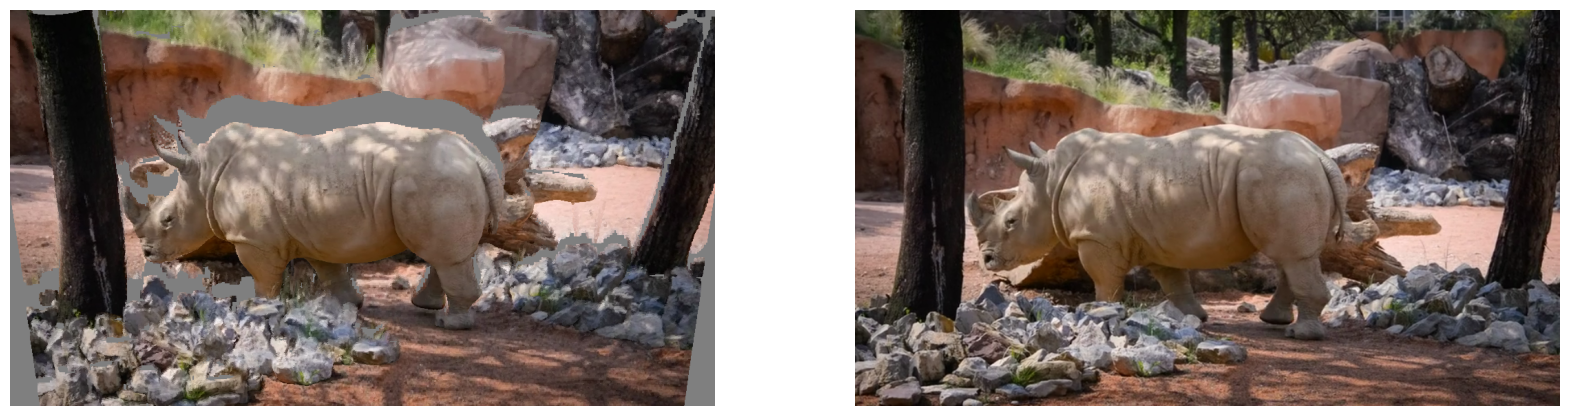

In [164]:
# plot the result
import matplotlib.pyplot as plt

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)

plt.imshow((warped_images[10][0].permute(1,2,0).cpu().numpy() + 1) / 2)
plt.axis('off')
plt.subplot(1,2,2)
# plt.imshow(masks[10][0].permute(1,2,0).cpu().numpy(), cmap='gray')
plt.imshow((frames_tensor[10].permute(1,2,0).cpu().numpy() + 1) / 2, cmap='gray')
plt.axis('off')
plt.show()

In [165]:
_, segment_dir = sample_diffusion(
    vis_crafter,
    frames_tensor,
    warped_images,
    frames_tensor[:10],
    masks,
    opts,
)

Saving to: ./experiments/11-10-2025/rhino_20251011_1207_90_0_0_0_1_auto_s2/stage_3


  0%|          | 0/50 [00:00<?, ?it/s]

(viser) Connection closed (1, 0 total)

In [166]:
########################################################
# Autoregressive Generation
########################################################

frames_gen_np = utils.read_video_frames(
    os.path.join(segment_dir, 'gen.mp4'), opts.video_length, opts.stride, opts.max_res,
)

# pad if too short
frames_gen_np = pad_video(frames_gen_np, opts.video_length)

# reverse the 0th axis
frames_gen_np = frames_gen_np[::-1, ...].copy()

# print(frames_gen_np.shape)

frames_gen_tensor = (
    torch.from_numpy(frames_gen_np).permute(0, 3, 1, 2).to(opts.device) * 2.0 - 1.0
)  # 49 576 1024 3 -> 49 3 576 1024, [-1,1]
assert frames_gen_tensor.shape[0] == opts.video_length


==> processing video:  ./experiments/11-10-2025/rhino_20251011_1207_90_0_0_0_1_auto_s2/stage_3/gen.mp4
==> original video shape:  (49, 384, 672, 3)
==> downsampled shape: (49, 576, 1024, 3), with stride: 1
==> final processing shape: (49, 576, 1024, 3)


In [178]:
frames_np.shape, frames_gen_np.shape

((49, 576, 1024, 3), (49, 576, 1024, 3))

In [167]:
# Before calling depth estimation, ensure consistent dtypes
with torch.autocast(device_type='cuda', dtype=torch.float16):
    depths_gen = vis_crafter.depth_estimater.infer(
        frames_gen_np,
        opts.near,
        opts.far,
        opts.depth_inference_steps,
        opts.depth_guidance_scale,
        window_size=opts.window_size,
        overlap=opts.overlap,
    ).to(opts.device)

Elapsed time for encoding video: 2086.427978515625 ms


  0%|          | 0/5 [00:00<?, ?it/s]

Elapsed time for denoising video: 6972.66845703125 ms
Elapsed time for decoding video: 6109.53271484375 ms


In [168]:
# Apply before 3D projection
depth_original = depths[0]  # Your first depth estimate
depth_generated = depths_gen[-1]  # Your second depth estimate

scale_factor = align_depth_maps(
    depth_original, depth_generated
)
print(f"Depth scale factor: {scale_factor:.3f}")

depths_gen_aligned = depths_gen * scale_factor

Depth scale factor: 0.789


In [169]:
point_clouds_gen = []
colors_list_gen = []
weights_list_gen = []

for i in tqdm(range(opts.video_length)):
    with torch.no_grad():
        points, colors, weights = funwarp.create_pointcloud_from_image(
            frames_gen_tensor[i:i+1],
            None,
            depths_gen_aligned[i:i+1],
            # traj_segments[0][i:i+1], should be reversed
            traj_segments[0][-i-1].unsqueeze(0),
            vis_crafter.K[i:i+1],
            1,
        )
    point_clouds_gen.append(points)
    colors_list_gen.append(colors)  
    weights_list_gen.append(weights)
    
    # add the new points to the ith global point cloud
    # global_pc[-i-1] = torch.cat([global_pc[-i-1], points], dim=0)
    # global_colors[-i-1] = torch.cat([global_colors[-i-1], colors], dim=0)
    
    # cat to global pc, then downsample
    pc_merged = torch.cat([global_pc[-i-1], points], dim=0)
    color_merged = torch.cat([global_colors[-i-1], colors], dim=0)
    
    # downsample by 2x randomly
    indices = torch.randperm(pc_merged.shape[0], device=pc_merged.device)[:2000000]
    pc_merged = pc_merged[indices]
    color_merged = color_merged[indices]
    
    global_pc[-i-1] = pc_merged
    global_colors[-i-1] = color_merged
    
    


100%|██████████| 49/49 [00:00<00:00, 69.79it/s]


In [170]:
warped_images_gen = []
masks_gen = []

for i in tqdm(range(opts.video_length)):
    warped_image, mask = funwarp.render_pointcloud_zbuffer_vectorized_point_size(
        # point_clouds_gen[i],
        # colors_list_gen[i],
        global_pc[-i-1],
        global_colors[-i-1],
        traj_segments[1][i:i+1],
        vis_crafter.K[0:1].to(opts.device),
        (576, 1024),
        point_size=2,
    )
    
    cleaned_mask = clean_single_mask_simple(
        mask[0],
        kernel_size=9,
        n_erosion_steps=1,
        n_dilation_steps=1
        )
    
    cleaned_mask = cleaned_mask.unsqueeze(0)
    
    warped_image = warped_image * cleaned_mask
    
    warped_images_gen.append(warped_image)
    masks_gen.append(cleaned_mask)


100%|██████████| 49/49 [00:00<00:00, 253.51it/s]


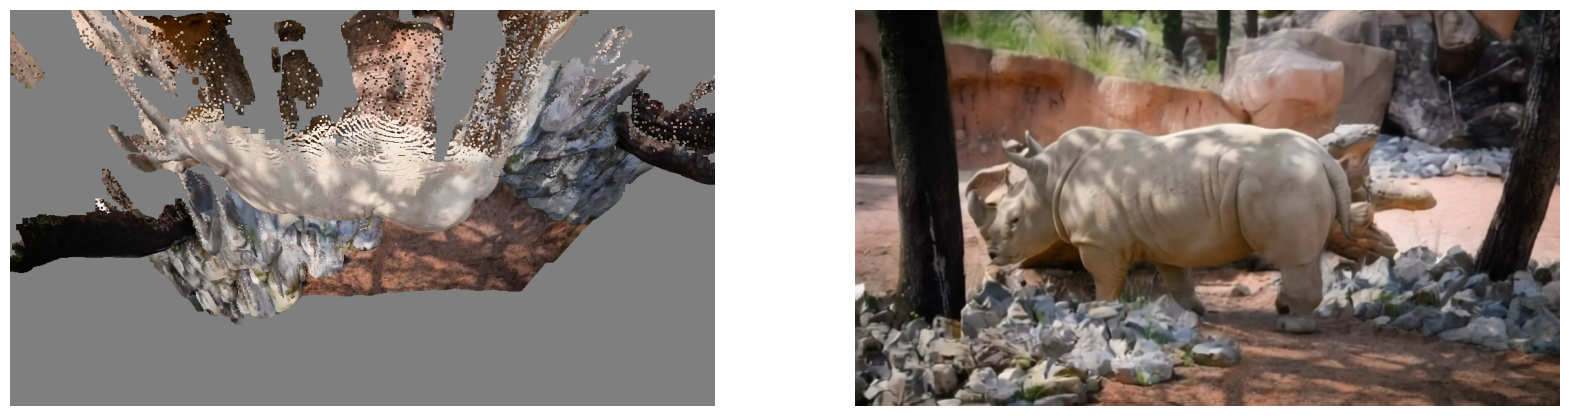

In [171]:
# plot the result
import matplotlib.pyplot as plt

j = 40

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)

plt.imshow((warped_images_gen[j][0].permute(1,2,0).cpu().numpy() + 1) / 2)
plt.axis('off')
plt.subplot(1,2,2)
# plt.imshow(masks[10][0].permute(1,2,0).cpu().numpy(), cmap='gray')
plt.imshow((frames_gen_tensor[j].permute(1,2,0).cpu().numpy() + 1) / 2, cmap='gray')
plt.axis('off')
plt.show()

In [172]:
sample_autoreg, segment_dir_autoreg = sample_diffusion(
    vis_crafter,
    frames_tensor=frames_gen_tensor,
    warped_images=warped_images_gen,
    frames_ref=frames_tensor[:10],
    masks=masks_gen,
    opts=opts
)


Saving to: ./experiments/11-10-2025/rhino_20251011_1207_90_0_0_0_1_auto_s2/stage_4


  0%|          | 0/50 [00:00<?, ?it/s]

In [173]:
frames_autoreg_np = utils.read_video_frames(
    os.path.join(segment_dir_autoreg, 'gen.mp4'), opts.video_length, opts.stride, opts.max_res,
)
# pad if too short
frames_autoreg_np = pad_video(frames_autoreg_np, opts.video_length)

frames_autoreg_np = frames_autoreg_np[::-1, ...].copy()
frames_autoreg_tensor = (
    torch.from_numpy(frames_autoreg_np).permute(0, 3, 1, 2).to(opts.device) * 2.0 - 1.0
)  # 49 576 1024 3 -> 49 3 576 1024, [-1,1]

==> processing video:  ./experiments/11-10-2025/rhino_20251011_1207_90_0_0_0_1_auto_s2/stage_4/gen.mp4
==> original video shape:  (49, 384, 672, 3)
==> downsampled shape: (49, 576, 1024, 3), with stride: 1
==> final processing shape: (49, 576, 1024, 3)


In [174]:
with torch.autocast(device_type='cuda', dtype=torch.float16):
    depths_autoreg = vis_crafter.depth_estimater.infer(
        frames_autoreg_np,
        opts.near,
        opts.far,
        opts.depth_inference_steps,
        opts.depth_guidance_scale,
        window_size=opts.window_size,
        overlap=opts.overlap,
    ).to(opts.device)

Elapsed time for encoding video: 2062.67138671875 ms


  0%|          | 0/5 [00:00<?, ?it/s]

Elapsed time for denoising video: 7150.646484375 ms
Elapsed time for decoding video: 6354.1162109375 ms


In [175]:
# estimate scale factor again
scale_factor_2 = align_depth_maps(
    depths_gen_aligned[0], depths_autoreg[-1]
)
print(f"Depth scale factor 2: {scale_factor_2:.3f}")
depths_autoreg_aligned = depths_autoreg * scale_factor_2

Depth scale factor 2: 0.957


In [176]:
point_clouds_autoreg = []
colors_list_autoreg = []
weights_list_autoreg = []

for i in tqdm(range(opts.video_length)):
    with torch.no_grad():
        points, colors, weights = funwarp.create_pointcloud_from_image(
            frames_autoreg_tensor[i:i+1],
            None,
            depths_autoreg_aligned[i:i+1],
            traj_segments[1][-i-1].unsqueeze(0),
            vis_crafter.K[i:i+1],
            1,
        )
    point_clouds_autoreg.append(points)
    colors_list_autoreg.append(colors)  
    weights_list_autoreg.append(weights)
    
    # global_pc[i] = torch.cat([global_pc[i], points], dim=0)
    # global_colors[i] = torch.cat([global_colors[i], colors], dim=0)
    
    pc_merged = torch.cat([global_pc[i], points], dim=0)
    color_merged = torch.cat([global_colors[i], colors], dim=0)
    
    # downsample by 2x randomly
    indices = torch.randperm(pc_merged.shape[0], device=pc_merged.device)[:2000000]
    pc_merged = pc_merged[indices]
    color_merged = color_merged[indices]
    
    global_pc[i] = pc_merged
    global_colors[i] = color_merged

100%|██████████| 49/49 [00:00<00:00, 407.91it/s]


## Viser utils

In [27]:
import viser
import numpy as np

# Start viser server
server = viser.ViserServer()

╭──────────────── viser ────────────────╮
│             ╷                         │
│   HTTP      │ http://localhost:8080   │
│   Websocket │ ws://localhost:8080     │
│             ╵                         │
╰───────────────────────────────────────╯

In [ ]:
# print slurm node name

node_name=os.environ.get('SLURM_NODELIST', 'localhost')

print(f'http://{node_name}:{server.get_port()}')



http://gpu24-h100-03:8080


(viser) Connection opened (0, 1 total), 5 persistent messages

In [44]:
def add_points(
    server,
    points: np.ndarray,  # (N, 3)
    colors: np.ndarray,  # (N, 3)
    name: str,
):
    # ensure colors are in [0, 1]
    if colors.min() < -0.1:
        colors = (colors + 1.0) / 2.0
    
    server.scene.add_point_cloud(
        name=name,
        points=points,
        colors=colors,
        point_size=0.01
    )

def add_camera(
    server,
    pose: np.ndarray,  # (4, 4)
    name: str,
    color: tuple = (0.2, 0.8, 0.2),
):
    pose = np.linalg.inv(pose)
    
    position = pose[:3, 3]
    rotation_matrix = pose[:3, :3]
    
    # Convert rotation to quaternion
    wxyz = viser.transforms.SO3.from_matrix(rotation_matrix).wxyz
    
    server.scene.add_camera_frustum(
        name,
        fov=60, aspect=4/3, scale=0.1,
        position=position, wxyz=wxyz,
        color=color
    )
    
# Add this after creating your server and adding point clouds
@server.on_client_connect
def _(client: viser.ClientHandle) -> None:
    yaw_slider = client.gui.add_slider("Camera Yaw", min=-180, max=180, step=1, initial_value=0)
    
    @yaw_slider.on_update
    def _(_):
        angle_rad = np.deg2rad(yaw_slider.value)
        radius = 8.0
        
        position = np.array([
            radius * np.sin(angle_rad),
            0,  # height
            radius * np.cos(angle_rad)
        ])
        
        client.camera.position = position
        client.camera.look_at = np.array([0, 0, 0])
        client.camera.up_direction = np.array([0, -1, 0])

(viser) Connection closed (0, 0 total)

(viser) Connection opened (1, 1 total), 403 persistent messages

In [177]:
server.scene.reset()

# add original point cloud #0, and all cameras from first segment

j = 45

add_points(
    server,
    point_clouds[j].cpu().numpy(),
    colors_list[j].cpu().numpy(),
    name='input_pc'
)
for idx in range(opts.video_length):
    add_camera(
        server,
        traj_segments[0][idx].cpu().numpy(),
        name=f'input_cam_{idx:02d}',
        color=(0.2, 0.8, 0.2)
    )
    
# add inpainted point cloud #1, and all cameras from second segment
add_points(
    server,
    point_clouds_gen[-j-1].cpu().numpy(),
    colors_list_gen[-j-1].cpu().numpy(),
    name='gen_pc'
)
for idx in range(opts.video_length):
    add_camera(
        server,
        traj_segments[1][idx].cpu().numpy(),
        name=f'gen_cam_{idx:02d}',
        color=(0.8, 0.2, 0.2)
    )
    
add_points(
    server,
    point_clouds_autoreg[j].cpu().numpy(),
    colors_list_autoreg[j].cpu().numpy(),
    name='autoreg_pc'
)

add_points(
    server,
    global_pc[j].cpu().numpy(),
    global_colors[j].cpu().numpy(),
    name='global_pc'
)

(viser) Connection opened (2, 1 total), 601 persistent messages

(viser) Connection closed (2, 0 total)

In [97]:
# remove vis_cam_XX if exists
for idx in range(opts.video_length):
    cam_name = f'vis_cam_{idx:02d}'
    if cam_name in server.scene.__dict__['_handle_from_node_name']:
        server.scene.remove_by_name(cam_name)


# add some cameras for visualization
c2ws_vis = generate_traj_specified(
    c2ws_anchor, 
    [120, 0, 0, 0, 3], 
    opts.video_length, 
    opts.device
)
c2ws_vis[:, 2, 3] += radius

# c2ws_vis[:, 2, 1] /= 2

# add cameras to viser
for idx in range(0, opts.video_length):
    add_camera(
        server,
        c2ws_vis[idx].cpu().numpy(),
        name=f'vis_cam_{idx:02d}',
        color=(0.2, 0.2, 0.8)
    )

In [ ]:
# TODO 
# Depth estimation on the input+generated sequence for consistency
# Can we use their warping code on multiple images?
# Implement this as a loop, with arbitraty number of steps

## Bin

In [ ]:
# get n of subdirs in /home/azhuravl/work/TrajectoryCrafter/experiments/10-10-2025/rhino_20251010_1009_right_90_auto_s2
import os


n_subdirs = len([name for name in os.listdir(opts.save_dir) if os.path.isdir(os.path.join(opts.save_dir, name))])

segment_dir = os.path.join(opts.save_dir, f'stage_{n_subdirs+1}')
print('saving to:', segment_dir)

os.makedirs(segment_dir, exist_ok=True)

cond_video = (torch.cat(warped_images) + 1.0) / 2.0
cond_masks = torch.cat(masks)

frames_interp = F.interpolate(
    frames_tensor, size=opts.sample_size, mode='bilinear', align_corners=False
)
cond_video = F.interpolate(
    cond_video, size=opts.sample_size, mode='bilinear', align_corners=False
)
# cond_video = frames_interp
cond_masks = F.interpolate(cond_masks, size=opts.sample_size, mode='nearest')

save_video(
    (frames_interp.permute(0, 2, 3, 1) + 1.0) / 2.0,
    os.path.join(segment_dir, 'input.mp4'),
    fps=opts.fps,
)
save_video(
    cond_video.permute(0, 2, 3, 1),
    os.path.join(segment_dir, 'render.mp4'),
    fps=opts.fps,
)
save_video(
    cond_masks.repeat(1, 3, 1, 1).permute(0, 2, 3, 1),
    os.path.join(segment_dir, 'mask.mp4'),
    fps=opts.fps,
)

# return

frames_interp = (frames_interp.permute(1, 0, 2, 3).unsqueeze(0) + 1.0) / 2.0
frames_ref = frames_interp[:, :, :10, :, :]
cond_video = cond_video.permute(1, 0, 2, 3).unsqueeze(0)

# cond_video = frames_interp


cond_masks = (1.0 - cond_masks.permute(1, 0, 2, 3).unsqueeze(0)) * 255.0
generator = torch.Generator(device=opts.device).manual_seed(opts.seed)

with torch.no_grad():            
    sample = vis_crafter.pipeline(
        vis_crafter.prompt,
        num_frames=opts.video_length,
        negative_prompt=opts.negative_prompt,
        height=opts.sample_size[0],
        width=opts.sample_size[1],
        generator=generator,
        guidance_scale=opts.diffusion_guidance_scale,
        num_inference_steps=opts.diffusion_inference_steps,
        video=cond_video.to(opts.device),
        mask_video=cond_masks.to(opts.device),
        reference=frames_ref.to(opts.device),
    ).videos

# sample = frames
    
save_video(
    sample[0].permute(1, 2, 3, 0),
    os.path.join(segment_dir, 'gen.mp4'),
    fps=opts.fps,
)
return sample

In [ ]:
for i in range(opts.n_splits):
    
    segment_dir = os.path.join(opts.save_dir, f'stage_{i+1}')
    os.makedirs(segment_dir, exist_ok=True)
    
    inpainted_video = generate_segment(
        frames, pc_input, color_input, traj_segments[i], segment_dir, opts
        )
    
    pc_inpainted = pc_input
    color_inpainted = color_input
    # pc_inpainted, color_inpainted = extract_point_cloud(inpainted_video, traj_segments[i], opts)
    
    # pc_merged, color_merged = merge_point_clouds(pc_input, color_input, pc_inpainted, color_inpainted)
    pc_merged, color_merged = pc_inpainted, color_inpainted
                
    save_segment_results(
        pc_input,
        color_input,
        pc_inpainted,
        color_inpainted,            
        pc_merged,
        color_merged,
        traj_segments[i],
        opts, segment_idx=i)
    
    frames = inpainted_video
    pc_input = pc_merged
    color_input = color_merged